<a href="https://colab.research.google.com/github/Cl8D/SSUML/blob/main/Project%204%20-%20Style%20Transfer%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**image_utils**

In [1]:
from __future__ import print_function
from future import standard_library
standard_library.install_aliases()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import numpy as np
import copy

from imageio import imread
from collections import namedtuple

from builtins import range
import urllib.request, urllib.error, urllib.parse, os, tempfile

%matplotlib inline

**code start**

In [2]:
# GPU 장치 사용 설정
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%cd ./drive/MyDrive

/content/drive/MyDrive


In [4]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# 이미지 전처리 
def preprocess(img, size=512):
    transform = T.Compose([
        T.Scale(size), #사이즈를 (512 x 512)로 바꾸어 준다
        T.ToTensor(), # 이미지를 Tensor로 바꾸어주는 작업.
        #Normalize 해주기
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(), # 이미지를 PIL 객체로 변경한다
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

answers = np.load('style-transfer-checks.npz')


In [5]:
dtype = torch.FloatTensor
# Load the pre-trained SqueezeNet model.
cnn = models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

for param in cnn.parameters():
    param.requires_grad = False

# 특징 추출하기
def extract_features(x, cnn):
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


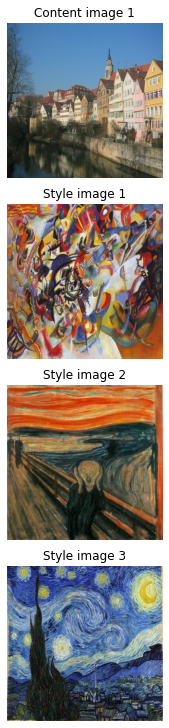

In [6]:
content_image1 = 'tubingen.jpg'
content1 = preprocess(PIL.Image.open(content_image1), size = (512, 512))

style_image1 = 'composition_vii.jpg'
style1 = preprocess(PIL.Image.open(style_image1), size = (512, 512))
style_image2 = 'the_scream.jpg'
style2 = preprocess(PIL.Image.open(style_image2), size = (512, 512))
style_image3 = 'starry_night.jpg'
style3 = preprocess(PIL.Image.open(style_image3), size = (512, 512))

f, axarr = plt.subplots(4, 1, constrained_layout = True, figsize = (10, 10))
axarr[0].axis('off')
axarr[0].set_title('Content image 1')
axarr[0].imshow(deprocess(content1.cpu()))

axarr[1].axis('off')
axarr[1].set_title('Style image 1')
axarr[1].imshow(deprocess(style1.cpu()))

axarr[2].axis('off')
axarr[2].set_title('Style image 2')
axarr[2].imshow(deprocess(style2.cpu()))

axarr[3].axis('off')
axarr[3].set_title('Style image 3')
axarr[3].imshow(deprocess(style3.cpu()))


# **Content Loss**

In [7]:
# content loss를 계산한다.(위에 나와있는 식 그대로 적용)
def content_loss(content_weight, content_current, content_original):
    # 2개의 feature representation 사이에서 나오는 squared-error loss를 정의한다.
    return content_weight * (content_current - content_original).pow(2).sum()

# **Style Loss**

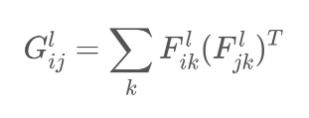

In [8]:
# style loss에 필요한 gram matrix를 정의한다.
def gram_matrix(features, normalize=True):
    N, C, H, W = features.size()
    reshaped = features.view(N, C, H*W)

    #torch.mm을 이용해서 행렬곱을 표현한다
    gram = torch.mm(reshaped[-1], reshaped[-1].t())
    
    # normalize를 할 경우
    if normalize:
      return gram / (H * W * C)
    else:
      return gram

In [9]:
# style loss를 정의한다.

# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    loss = Variable(torch.zeros(1).cuda())
    for i in range(len(style_layers)):
      gram = gram_matrix(feats[style_layers[i]])
      loss += style_weights[i] * (gram - style_targets[i]).pow(2).sum()
    return loss


In [10]:
def tv_loss(img, tv_weight):
    # Your implementation should be vectorized and not require any loops!
    w_variance = torch.sum((img[:,:,:,1:] - img[:,:,:,:-1])**2)
    h_variance = torch.sum((img[:,:,1:,:] - img[:,:,:-1,:])**2)
         
    return tv_weight * (w_variance + h_variance)


# **Importing Model**

In [11]:
# 뉴럴 네트워크 모델을 불러옵니다.(VGG19 사용)
# 이미지를 넣은 다음에 각 레이어에 대한 output feature 값을 얻기
#cnn = models.vgg19(pretrained=True).features.to(device).eval()

#cnn = models.vgg19(pretrained=True).features.eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 

In [12]:
'''
# loss를 계산하기 위해 필요한 depth
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    content_losses = []
    style_losses = []

    model = nn.Sequential()

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            content_loss1 = content_loss(deprocess(content_img))
            model.add_module("content_loss_{}".format(i), content_loss1)
            content_losses.append(content_loss1)

        if name in style_layers:
            # add style loss:
            style_loss1 = style_loss(deprocess(style_img))
            model.add_module("style_loss_{}".format(i), style_loss1)
            style_losses.append(style_loss1)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], content_loss1) or isinstance(model[i], style_loss1):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
'''

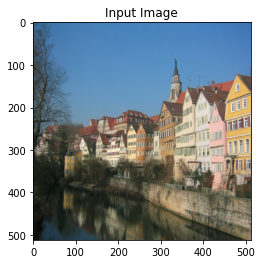

In [13]:
'''
input_img = content1.clone()

plt.title('Input Image')
plt.imshow(deprocess(input_img.cpu()))
'''

In [14]:
'''
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img
'''

In [15]:
'''
output = run_style_transfer(cnn, SQUEEZENET_MEAN, SQUEEZENET_STD,
                            content1, style1, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
'''

"\noutput = run_style_transfer(cnn, SQUEEZENET_MEAN, SQUEEZENET_STD,\n                            content1, style1, input_img)\n\nplt.figure()\nimshow(output, title='Output Image')\n\n# sphinx_gallery_thumbnail_number = 4\nplt.ioff()\nplt.show()\n"

In [26]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    content_img_var = Variable(content_img.type(dtype))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    style_img_var = Variable(style_img.type(dtype))
    feats = extract_features(style_img_var, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img_var Torch variable, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img_var], lr=initial_lr)

    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img_var, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img_var, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward(retain_graph = True)
        
        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img_var], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.cpu()))
    plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


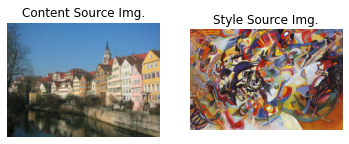

Iteration 0


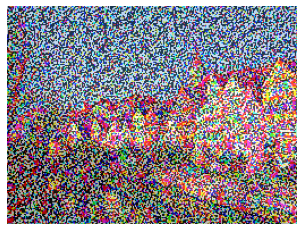

Iteration 100


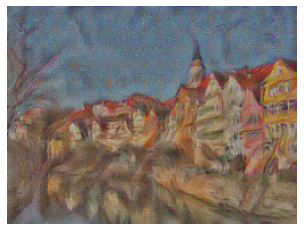

Iteration 199


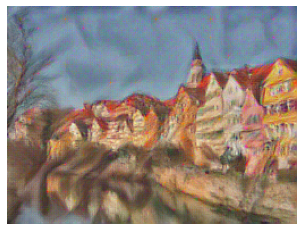

In [27]:
params1 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


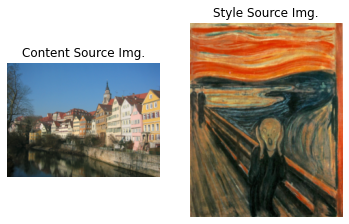

Iteration 0


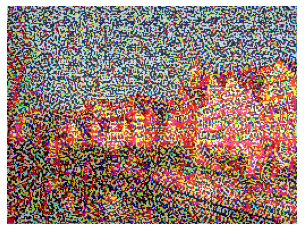

Iteration 100


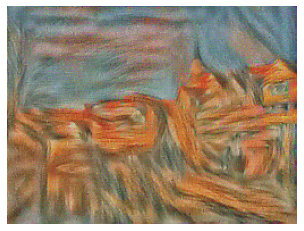

Iteration 199


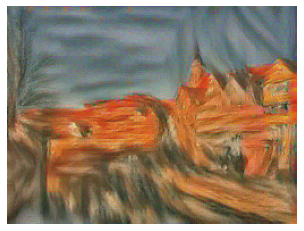

In [28]:
params2 = {
    'content_image':'tubingen.jpg',
    'style_image':'the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


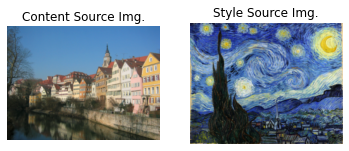

Iteration 0


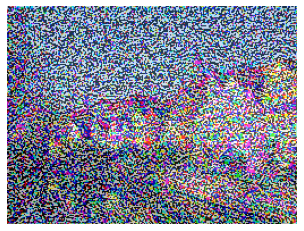

Iteration 100


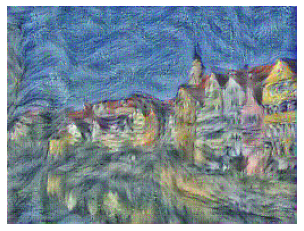

Iteration 199


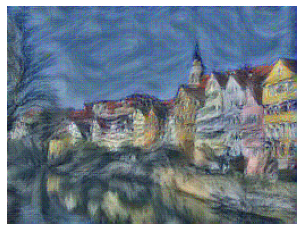

In [29]:
params3 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


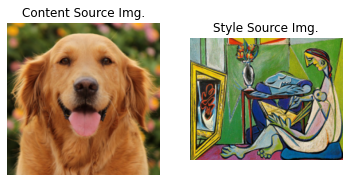

Iteration 0


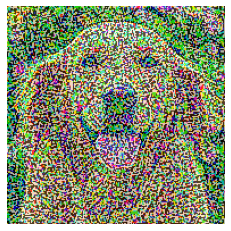

Iteration 100


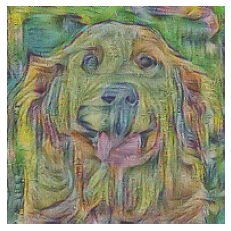

Iteration 199


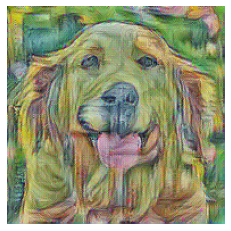

In [33]:
params4 = {
    'content_image' : 'content_img_2.jpg',
    'style_image' : 'muse.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params4)